In [31]:
import os, re, numpy as np
from skimage.io import imread
import argparse, yaml
import tifffile
from joblib import Parallel, delayed
from functools import partial

# parser = argparse.ArgumentParser()
# parser.add_argument('param_file')
# args = parser.parse_args()
# params = yaml.safe_load(open(args.param_file, "r"))
params = yaml.safe_load(open("params_2dreg-Sample2.yaml", "r"))

#Raw Data Folder
dir_data_raw = params['dir_nikon_data']

#Where Aligned MIPs are written to
dir_output_aligned = params['dir_data_raw'] # "../0_raw_adapted/"# 
if not os.path.isdir(dir_output_aligned):
    os.makedirs(dir_output_aligned)

#rounds
rnd_list = params['reg_rounds']
rnd_dict = params['rounds_dir']
# filePat3d = {'SFD4258-Young':'Point(?P\\d+)_ZStack(?P\\d+)_Channel.*_Seq(?P\\d+).ome.tiff$'}
# filePat3d = {'SFD4258-Young':'Point(?P<fov>\\d+)_ZStack(?P<z>\\d+)_Channel.*Seq(?P<seq>\\d+).ome.tiff$'}
filePat3d = {'SFD4259-Young':'{}(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*Seq(?P<seq>\\d+).ome.tiff$'}
# filePat3d = "{}(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*.ome.tiff$"Seq0000.ome.tiff'
# regex3d = {key:re.compile(filePat3d[key].format(".*Point")) for key in rnd_list}
regex3d = {key:re.compile(params['rounds_regex3d'][key]) for key in params['rounds_regex3d']}

In [27]:
params['rounds_regex3d']

{'Sample1': '.*Point(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*Seq(?P<seq>\\d+).ome.tiff$'}

In [8]:
'Point0017_ZStack0022_ChannelDAPI,AF488,AF568,AF647,TD_Seq0413.ome.tiff'

'Time00000_.*Point(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*.ome.tiff$'

In [28]:
def adaptMultiCh(filename, inputdir, outputdir, regex, metadata_file):
    """
    Convert filename to be compatible to DF analysis workflow
    """
    fov_str = 's' + str(int(regex.match(filename).group('fov'))).zfill(n_imgs_width)
    z_str = 'z' + str(int(regex.match(filename).group('z'))).zfill(n_z_width) 
    multich = tifffile.imread(os.path.join(inputdir, filename))
    if multich.shape[0] == min(multich.shape):
        multich = np.moveaxis(multich, 0, -1)
    for ch in range(min(multich.shape)):
        ch_str = "ch{:02}".format(ch)
        new_name = "{0}_{1}_{2}_{3}.tif".format(rnd, fov_str, z_str, ch_str)
        tifffile.imwrite(os.path.join(outputdir, new_name), 
                        multich[..., ch], imagej=True, photometric = 'minisblack', compression="zlib")
def adaptMetadat(filename, inputdir, outputdir, regex, metadata_file):
    """
    Generate metadata file from raw ome tiff file
    """
    fov_str = 's' + str(int(regex.match(filename).group('fov'))).zfill(n_imgs_width)
    z_str = 'z' + str(int(regex.match(filename).group('z'))).zfill(n_z_width) 
    print(fov_str,z_str)
    with open(metadata_file,'a') as f:
        if int(regex.match(filename).group('z')) == 0:
            for tag in tifffile.TiffFile(os.path.join(inputdir, filename)).pages[0].tags.values():
                if tag.name == 'ImageWidth':
                    ImageWidth = tag.value
                if tag.name == 'ImageLength':
                    ImageLength = tag.value
                if tag.name == '65326':
                    PixelSize = tag.value
                if tag.name == '65329':
                    dXPosition = tag.value[0]
                    dYPosition = tag.value[1]
                    dZPosition = tag.value[2]
            n_seq_width = len(regex.match(filename).group('seq'))
            seq_str = 'Seq' + str(int(regex.match(filename).group('seq'))).zfill(n_seq_width)
            new_seq_str = 'Seq' + str(int(regex.match(filename).group('seq'))+1).zfill(n_seq_width)
            next_file = filename.replace('ZStack0000', 'ZStack0001').replace(seq_str, new_seq_str)
            print(seq_str, new_seq_str,next_file)
            for tag in tifffile.TiffFile(os.path.join(inputdir, next_file)).pages[0].tags.values():
                if tag.name == '65329':
                    dZPosition_new = tag.value[2]
            ZStepSize = abs(dZPosition_new - dZPosition)
            f.write(f'{fov_str},{dXPosition},{dYPosition},{dZPosition},{ImageWidth},{ImageLength},{PixelSize},{ZStepSize}\n')

In [10]:
files[0]

IndexError: list index out of range

In [ ]:
for tag in tifffile.TiffFile(os.path.join(inputdir, files[0])).pages[0].tags.values():
    print(tag.name, tag.value)

In [ ]:
for tag in tifffile.TiffFile(os.path.join(inputdir, files[1])).pages[0].tags.values():
    print(tag.name, tag.value)

In [ ]:
inputdir=os.path.join(dir_data_raw, rnd_dict[rnd])
filename = file
for tag in tifffile.TiffFile(os.path.join(inputdir, filename)).pages[0].tags.values():
    print(f"{tag.name}: {tag.value}")

In [31]:
os.listdir(os.path.join(dir_data_raw, rnd_dict[rnd]))[0]

'Point0017_ZStack0022_ChannelDAPI,AF488,AF568,AF647,TD_Seq0413.ome.tiff'

In [21]:
regex = re.compile('.*Point(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*Seq(?P<seq>\\d+).ome.tiff$')
regex.match('Point0016_ZStack0030_ChannelDAPI,AF488,AF568,AF647,TD_Seq0542.ome.tiff')

<re.Match object; span=(0, 70), match='Point0016_ZStack0030_ChannelDAPI,AF488,AF568,AF64>

In [24]:
re.compile('.*Point(?P<fov>\\d+)_ZStack(?P<z>\\d+)_.*Seq(?P<seq>\\d+).ome.tiff$')

re.compile(r'.*Point(?P<fov>\d+)_ZStack(?P<z>\d+)_.*Seq(?P<seq>\d+).ome.tiff$',
           re.UNICODE)

In [ ]:
os.listdir(os.path.join(dir_data_raw, rnd_dict[rnd]))

In [33]:
a = ['1','2','3']
a[:2] = ['2','3']
a

['2', '3', '3']

In [34]:
str(12)

'12'

In [32]:
for rnd in rnd_list:
    regex = regex3d[rnd]
    
    files = [file for file in os.listdir(os.path.join(dir_data_raw, rnd_dict[rnd])) 
                                         if regex.match(file)]
    files = sorted(files)
    print(files[0:10])
    n_imgs_width = len(str(len(set([regex.match(file).group('fov') for file in files]))))
    n_z_width = len(str(len(set([regex.match(file).group('z') for file in files]))))
    n_seq_width = len(str(len(set([regex.match(file).group('seq') for file in files]))))
    print(n_imgs_width,n_z_width,n_seq_width)
    rnd_dir = os.path.join(dir_output_aligned, rnd)
    metadata_file = os.path.join(dir_output_aligned, 'metadata.csv')
    with open(metadata_file, 'w') as file:
        file.write('Point,dXPosition,dYPosition,dZPosition,ImageWidth,ImageLength,PixelSize,ZStepSize\n')
    if not os.path.exists(rnd_dir):
        os.mkdir(rnd_dir)
    for file in files:
        print(file)
        adaptMetadat(file, inputdir=os.path.join(dir_data_raw, rnd_dict[rnd]), 
                      outputdir=rnd_dir, regex = regex, metadata_file = metadata_file)
    adaptPartial = partial(adaptMultiCh, inputdir=os.path.join(dir_data_raw, rnd_dict[rnd]), 
                           outputdir=rnd_dir, regex=regex, metadata_file = metadata_file)
    Parallel(n_jobs=20, prefer='processes')(delayed(adaptPartial)(file) for file in files)


['Point0000_ZStack0000_ChannelDAPI,AF488,AF568,AF647,TD_Seq0000.ome.tiff', 'Point0000_ZStack0001_ChannelDAPI,AF488,AF568,AF647,TD_Seq0001.ome.tiff', 'Point0000_ZStack0002_ChannelDAPI,AF488,AF568,AF647,TD_Seq0002.ome.tiff', 'Point0000_ZStack0003_ChannelDAPI,AF488,AF568,AF647,TD_Seq0003.ome.tiff', 'Point0000_ZStack0004_ChannelDAPI,AF488,AF568,AF647,TD_Seq0004.ome.tiff', 'Point0000_ZStack0005_ChannelDAPI,AF488,AF568,AF647,TD_Seq0005.ome.tiff', 'Point0000_ZStack0006_ChannelDAPI,AF488,AF568,AF647,TD_Seq0006.ome.tiff', 'Point0000_ZStack0007_ChannelDAPI,AF488,AF568,AF647,TD_Seq0007.ome.tiff', 'Point0000_ZStack0008_ChannelDAPI,AF488,AF568,AF647,TD_Seq0008.ome.tiff', 'Point0000_ZStack0009_ChannelDAPI,AF488,AF568,AF647,TD_Seq0009.ome.tiff']
2 2 3
Point0000_ZStack0000_ChannelDAPI,AF488,AF568,AF647,TD_Seq0000.ome.tiff
s00 z00
Seq0000 Seq0001 Point0000_ZStack0001_ChannelDAPI,AF488,AF568,AF647,TD_Seq0001.ome.tiff
Point0000_ZStack0001_ChannelDAPI,AF488,AF568,AF647,TD_Seq0001.ome.tiff
s00 z01
Point000

In [91]:
def getMetaData(metadataXml):
    metadata = pd.read_csv(metadataXml)
    n_pixels = metadata['ImageWidth'][0]
    voxelSizes = (metadata['PixelSize'][0], metadata['PixelSize'][0], metadata['ZStepSize'][0])
    return n_pixels, voxelSizes, len(metadata)

'Time00000_Point0000_ZStack0000_ChannelDAPI,AF488,AF568,AF647,TD_Seq0000.ome.tiff'

In [ ]:
# adaptPartial = partial(adaptMultiCh, inputdir=os.path.join(dir_data_raw, rnd), 
#                            outputdir=rnd_dir)
# # adaptPartial[0]
files = [file for file in os.listdir(os.path.join(dir_data_raw, "5_dc4")) 
                                         if regex3d.match(file)]
im = imread(os.path.join(dir_data_raw, "5_dc4", files[0]))
im.shape

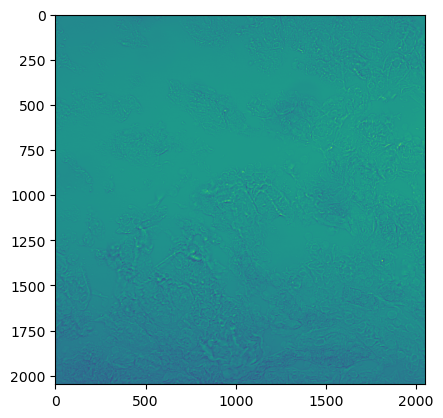

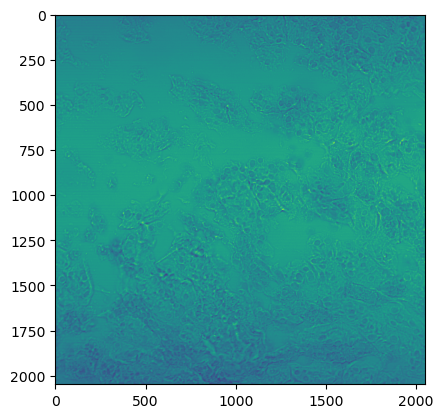

In [6]:
from matplotlib import pyplot as plt 
im1 = imread(os.path.join(dir_data_raw, "5_dc4", 'Point0196_ZStack0005_ChannelAF488,Cy3,AF647,TD_Seq3533.ome.tiff'))
im2 = imread(os.path.join(dir_data_raw, "8_DRAQ5_2", 'Point0196_ZStack0005_ChannelAF647,TD_Seq3533.ome.tiff'))
im1.shape, im2.shape
plt.imshow(im1[..., -1])
plt.figure()
plt.imshow(im2[-1])

In [15]:
import numpy as np
np.moveaxis(im2, 0, -1).shape

(2048, 2048, 2)

In [24]:
files = [file for file in os.listdir(os.path.join(dir_data_raw, "8_DRAQ5_2")) 
                                         if regex3d.match(file)]
[a for a in sorted(files) if a.startswith('Point0196')]

['Point0196_ZStack0000_ChannelAF647,TD_Seq3528.ome.tiff',
 'Point0196_ZStack0001_ChannelAF647,TD_Seq3529.ome.tiff',
 'Point0196_ZStack0002_ChannelAF647,TD_Seq3530.ome.tiff',
 'Point0196_ZStack0003_ChannelAF647,TD_Seq3531.ome.tiff',
 'Point0196_ZStack0004_ChannelAF647,TD_Seq3532.ome.tiff',
 'Point0196_ZStack0005_ChannelAF647,TD_Seq3533.ome.tiff',
 'Point0196_ZStack0006_ChannelAF647,TD_Seq3534.ome.tiff',
 'Point0196_ZStack0007_ChannelAF647,TD_Seq3535.ome.tiff',
 'Point0196_ZStack0008_ChannelAF647,TD_Seq3536.ome.tiff',
 'Point0196_ZStack0009_ChannelAF647,TD_Seq3537.ome.tiff',
 'Point0196_ZStack0010_ChannelAF647,TD_Seq3538.ome.tiff',
 'Point0196_ZStack0011_ChannelAF647,TD_Seq3539.ome.tiff',
 'Point0196_ZStack0012_ChannelAF647,TD_Seq3540.ome.tiff',
 'Point0196_ZStack0013_ChannelAF647,TD_Seq3541.ome.tiff',
 'Point0196_ZStack0014_ChannelAF647,TD_Seq3542.ome.tiff',
 'Point0196_ZStack0015_ChannelAF647,TD_Seq3543.ome.tiff',
 'Point0196_ZStack0016_ChannelAF647,TD_Seq3544.ome.tiff',
 'Point0196_ZS

In [29]:
min(im2.shape)

2

In [15]:
umPerPx = 0.4
tree = ET.parse('../multipoints-Copy1.xml')
root = tree.getroot()
tiles_px = []
for child in root[0]:
    if child.tag.startswith("Point"):
        pos_x = -float(child.find("./dXPosition").get('value')) / umPerPx
        pos_y = float(child.find("./dYPosition").get('value')) / umPerPx
        tiles_px.append((pos_x, pos_y))
tiles_px

[(3340.235780619646, 5733.63081350622),
 (2107.1784236164276, 5706.463650405932),
 (874.1210666132096, 5679.2964873056435),
 (-358.9362903900088, 5652.129324205354),
 (-1591.9936473932262, 5624.962161105066),
 (-2825.051004396444, 5597.794998004779),
 (-4058.1083613996625, 5570.627834904491),
 (-5291.165718402879, 5543.460671804202),
 (-7730.1132693090285, 4256.068988600407),
 (-6497.055912305811, 4283.236151700696),
 (-5263.998555302592, 4310.403314800983),
 (-4030.9411982993747, 4337.570477901271),
 (-2797.883841296156, 4364.7376410015595),
 (-1564.8264842929377, 4391.904804101848),
 (-331.76912728972053, 4419.071967202137),
 (901.2882297134979, 4446.239130302424),
 (2134.3455867167163, 4473.406293402713),
 (3367.402943719934, 4500.573456503001),
 (4600.460300723152, 4527.74061960329),
 (5833.51765772637, 4554.907782703578),
 (7066.5750147295885, 4582.074945803866),
 (8299.632371732805, 4609.2421089041545),
 (16958.20103385562, 3566.3548936029547),
 (15725.143676852405, 3539.18773050

In [16]:
len(root[0])

302

In [13]:
tree = ET.parse('../multipoints-Copy1.xml')
root = tree.getroot()
dimDscrpt = [item for item in root.findall("./Image/ImageDescription/Dimensions/DimensionDescription")]
dimDscrpt

[<Element 'no_name' at 0x7f40806ea8e0>]